# section7

## アンサンブル学習　ー異なるモデルの組み合わせ

- 多数決に基づく予測
- **バギング**を使ってトレーニングでーたのランダムな組み合わせを繰り返し抽出することによって、過学習を抑制。
- **ブースティング**の適用により、後藤から学習する「弱学習機」による強力なモデルの構築

In [2]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np

In [15]:
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key,
                                  value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
    
    def fit(self, X, y):
        self.lablec_ = LabelEncoder()
        self.lablec_.fit(y)
        self.classes_ = self.lablec_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablec_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maf_vote = np.apply_along_axis(
                lambda x:
                np.argmax(np.bincount(x, weights=self.weights)),
                axis=1,
                arr=predictions)
        
        maj_vote = self.lablenc_inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X)
                            for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

In [6]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

In [7]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

In [9]:
clf1 = LogisticRegression(penalty='l2',
                          C=0.001,
                          random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')
pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])
clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print('ROC AUC: %0.2f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.87 (+/- 0.17) [Logistic regression]
ROC AUC: 0.89 (+/- 0.16) [Decision tree]
ROC AUC: 0.88 (+/- 0.15) [KNN]


In [34]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print('ROC AUC: %0.2f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), label))

ROC AUC: 0.87 (+/- 0.17) [Logistic regression]
ROC AUC: 0.89 (+/- 0.16) [Decision tree]
ROC AUC: 0.88 (+/- 0.15) [KNN]
ROC AUC: 0.94 (+/- 0.13) [Majority voting]


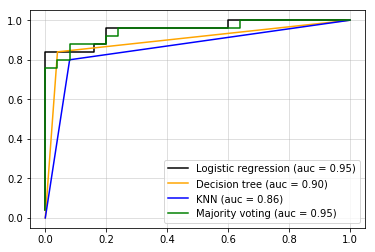

In [35]:
% matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', ':', ':', ':']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             #linestyles=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))
plt.grid(alpha=0.5)
plt.legend(loc='lower right')

In [36]:
from sklearn.model_selection import GridSearchCV
params = {'decisiontreeclassifer__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

ValueError: Invalid parameter decisiontreeclassifer for estimator MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', ra...ski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')]])],
            vote='classlabel', weights=None). Check the list of available parameters with `estimator.get_params().keys()`.

In [45]:
from scipy.special import comb
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import operator
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from itertools import product
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier

In [46]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

# if the Wine dataset is temporarily unavailable from the
# UCI machine learning repository, un-comment the following line
# of code to load the dataset from a local path:

# df_wine = pd.read_csv('wine.data', header=None)

# drop 1 class
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

In [47]:
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =            train_test_split(X, y, 
                             test_size=0.2, 
                             random_state=1,
                             stratify=y)

In [52]:
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=None,
                              random_state=1)
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500,
                        max_samples=1.0,
                        max_features=1.0,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=1)

## バギングとは？
アンサンブル学習の一つ。  
ブーストラップ標本（ランダムな復元抽出（ランダムに特徴量を選ぶ））

In [56]:
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision Tree Score: train=%.2f, test=%.2f' % (tree_train, tree_test))

Decision Tree Score: train=1.00, test=0.83


↑過学習がひどい

In [59]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Bagging Classifier Score: train=%.2f, test=%.2f' % (bag_train, bag_test))

Bagging Classifier Score: train=1.00, test=0.92


↑バギングでの予測のほうが汎化性能が高い

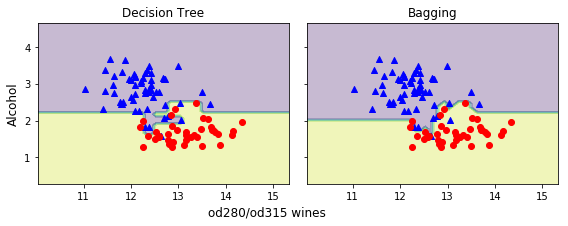

In [91]:
x_min = np.min(X_train[:, 0]) - 1
x_max = np.max(X_train[:, 0]) + 1
y_min = np.min(X_train[:, 1]) - 1
y_max = np.max(X_train[:, 1]) + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=2,
                       sharex='col',
                       sharey='row',
                       figsize=(8, 3))
d = 'Decision Tree'
b = 'Bagging'
for idx, clf, tt in zip([0, 1], [tree, bag], [d, b]):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c='red', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(9.2, -0.5,
         s='od280/od315 wines',
         ha='center', va='center', fontsize=12)
plt.tight_layout()
plt.show()

バギングはバリアンスの抑制には効果的である。ただし、バイアスの抑制には効果がない。つまり、バイアスが低い分類からなるアンサンブルでバギングを実行するとよい。

## ブースティングとは？
バギングとは対照的にトレーニングセットからはランダムに非復元抽出されたものを扱う。  
バギングと比べてバイアスとバリアンスが低くなることがある。だが、実際はバリアンスが高く過学習に陥りやすい傾向がある。

### ブースティングの原型版の手続き
1. 全体データセットDからサブセットd1（ランダムな非復元抽出）を作る。弱学習機C1で学習。
2. 二つ目のd2に1で誤分類されたデータの50%を追加しC2で学習。
3. DからC1とC2の結果が異なるデータd3を洗い出し、C3を学習する。
4. C1,C2,C3を多数決により組み合わせる。

### アダブーストによる手続き
アダブーストはトレーニングデータセット全体を使って弱学習機をトレーニングする。  
トレーニングサンプルはイテレーションのたびに重み付けされる。  
アンサンブルに含まれる学習済みの弱学習機の誤答から学習する強学習機を構築する。

In [94]:
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=1,
                              random_state=1)
ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500,
                         learning_rate=0.1,
                         random_state=1)
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision Tree Accuracy: train=%.3f, test=%.3f' % (tree_train, tree_test))

Decision Tree Accuracy: train=0.916, test=0.875


In [95]:
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('Ada Boost Accuracy: train=%.3f, test=%.3f' % (ada_train, ada_test))

Ada Boost Accuracy: train=1.000, test=0.917


↑モデルのバイアスを減らそうとした結果、かえってバリアンスが増えたことがわかる。